
<font size="6"> Final Project In Deep Learning 2020-21 </font>


<font size="4"> 10/07/2021 </font>

Submitted by: Artem Zinenko

## Introduction


Multi-class texture analysis in colorectal cancer histology

Automatic recognition of different  tissue types in histological images is an essential part in the digital pathology toolbox.
Texture analysis is commonly used to address this problem; 
mainly in the context of estimating the tumour/stroma ratio on histological samples. 

In this paper we present a new dataset of 5,000 histological images of human colorectal cancer including eight different  types of tissue. 

We used this set to assess the classification performance of a wide range of texture descriptors and classification.

## Dataset  
Anonymized H&E stained CRC tissue slides were obtained from the pathology archive at the University Medical Center Mannheim (Heidelberg University, Mannheim, Germany).

### Train set

Label name of category 
and 625 non-overlapping tissue for each label 
tiles of dimension 150X150 px (74X74 μm).

### Test set

Ten anonymized H&E stained CRC tissue 5000X5000 px

### Categories
Eight categories of cells:

(a) tumour epithelium, 

(b) simple stroma, 

(c) complex stroma (stroma that contains single tumour cells and/or single immune cells), 

(d) immune cell conglomerates, 

(e) debris and mucus,  

(f) mucosal glands, 

(g) adipose tissue, 

(h) background.

## References 
Link to Article : https://www.researchgate.net/publication/303998214_Multi-class_texture_analysis_in_colorectal_cancer_histology

Link to Dataset : https://knowyourdata-tfds.withgoogle.com/#tab=STATS&dataset=colorectal_histology

## Import Library

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization,Dropout,InputLayer
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

# Load Dataset
import tensorflow_datasets as tfds

# Helper libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import DistanceMetric
from seaborn import heatmap 
from sklearn.manifold import TSNE

print(tf.__version__)

2.5.0


## General Function



In [ ]:

def plot_history_after_training(i_History): # Prints the graphs of accuracy and losst
                                            #for the test and training set
    plt.figure(figsize=(14,4))
    plt.subplot(1,2,1)
    plt.plot(i_History.history['loss'],':or',label = "Train Data")
    plt.plot(i_History.history['val_loss'],'-og',label = "Test Data")
    plt.title('Loss',fontsize=14)
    plt.xlabel('Epochs',fontsize=14)
    plt.legend(loc = "upper left")
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(i_History.history['accuracy'],':ob',label = "Train Data")
    plt.plot(i_History.history['val_accuracy'],'-oc',label = "Test Data")
    plt.ylim([0, 1])
    plt.title('Accuracy',fontsize=12)
    plt.xlabel('Epochs',fontsize=12)
    plt.legend(loc = "upper left")
    plt.grid()

def load_img_and_leabl(): # get the raw data from database in tensorflow

    raw_data  = tfds.as_numpy(tfds.load(
    'colorectal_histology',
    split=['train'],
    batch_size=-1,
    shuffle_files = True,
    as_supervised=True,))
  
    img = raw_data[0][0]      # Extract the img and leabl from raw data
    leabl = raw_data[0][1]    

    return img ,leabl

def split_to_train_and_test(X, y, test_ratio, rand_state = None): # split data to train and test
    return train_test_split(X, y, test_size = test_ratio, random_state = rand_state)

def get_trin_and_test_generator(train_images, train_labels, test_images, test_labels):

    # preparing the test and train generator 
    data_gen_trin = ImageDataGenerator(
    rescale=1./255,  ##  Normalize images because it is better for all numbers to be between 0 and 1
    rotation_range=15,   
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1,
    shear_range=0.2,
    horizontal_flip=True)
     
    # data_gen_test =  ImageDataGenerator(rescale=1./255)

    train_generator = data_gen_trin.flow(x = train_images,y=train_labels,batch_size=32,shuffle=True)
    test_generator = data_gen_trin.flow(x = test_images,y=test_labels,batch_size=32,shuffle=True)

    return train_generator, test_generator

def plot_generator_images(train_generator, all_label_dictionary): # plot some images from generator

  x_batch, y_batch = train_generator.next() # Get some images (x_batch) and label (y_batch)
                                            # that is batch_size = 32
  plt.figure(figsize=(15,8))                # plot this imgas
  for i,x in enumerate(x_batch):
      plt.subplot(4,8,i+1)
      plt.imshow(x)
      plt.title(all_label_dictionary.get(y_batch[i]))
      plt.axis('off')

  print('x_batch.shape = ',x_batch.shape)
  print('y_batch.shape = ',y_batch.shape)

def plot_confusion_matrix(model, class_names, test_img, test_labels, model_name): 
# plot the confusion matrix                                   
# after we train the model                                           
# we can know for which categories the model predict more or less good              
  yhat_1_hot = model.predict(test_img)         ## model predict and get the pridict matrix one row for each image                                
  yhat = np.argmax(yhat_1_hot, axis=1)         ## yhat is array of Maximum probability for each image
  matrix = confusion_matrix(test_labels, yhat) ## using function confusion_matrix to get confusion Matrix
  confusion_normalized_matrix = matrix / matrix.sum(axis=1) # normalize each row (to sum = 1)

  plt.figure(figsize=(10,8)) ## plot the matrix
  heatmap(confusion_normalized_matrix,xticklabels=class_names, yticklabels=class_names,cmap='Blues',annot=True, fmt='.2%')
  plt.xlabel('Predicted label', fontsize=18)
  plt.ylabel('True label', fontsize=18)
  plt.title(str(model_name),fontsize=20)
  plt.show()

def get_accuracy_and_loss(model, test_images, test_labels):
  return model.evaluate(test_images, test_labels, verbose=0)


## Preparation Dataset



In [ ]:
img, lebal = load_img_and_leabl() # get images and her labels

In [ ]:
print('''Raw Data
Images: {0}
Each image size is: {1}  
Leabl: {2}  '''.format(img.shape[0],img.shape[1::],lebal.shape[0]))

Raw Data
Images: 5000
Each image size is: (150, 150, 3)  
Leabl: 5000  


In [ ]:
all_label_dictionary = {0 : "Tumor" ,1 : "Debris" ,2 : "Stroma" ,3 : "Lympho" , 4 : "complex" , 5 : "Mucosa" ,6 : "Adipose"  ,7 : "Empty",  }
all_label_dictionary # this is dictionary of all categories 

{0: 'Tumor',
 1: 'Debris',
 2: 'Stroma',
 3: 'Lympho',
 4: 'complex',
 5: 'Mucosa',
 6: 'Adipose',
 7: 'Empty'}

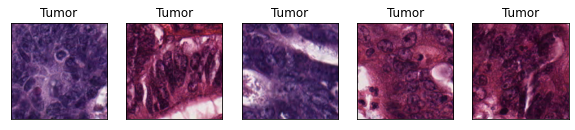

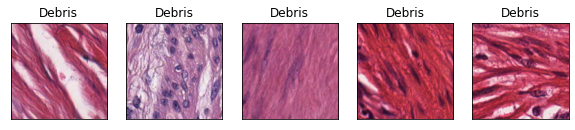

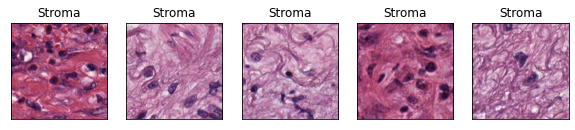

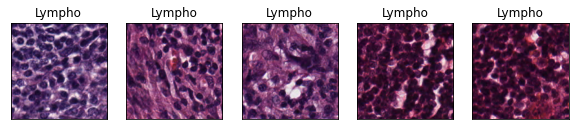

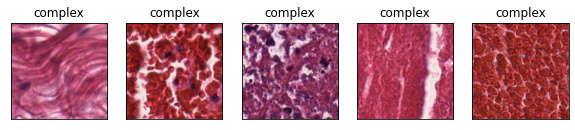

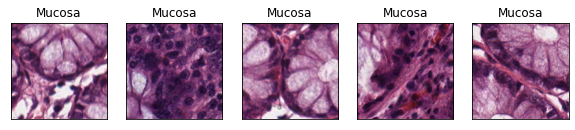

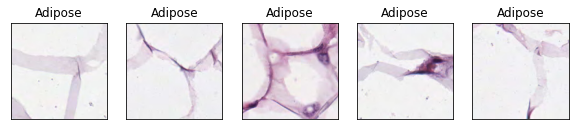

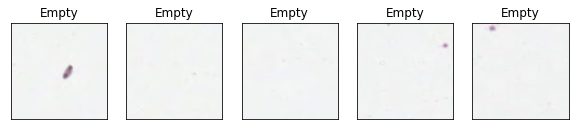

In [ ]:
for j in range(0,8,1):   # polt some images
    [idx] = np.where(lebal==j) 
    plt.figure(figsize=(10,5))
    for i in range(5):
        plt.subplot(1,5,i+1)
        plt.imshow(img[idx[i]])   
        plt.xticks([]), plt.yticks([])
        plt.title(all_label_dictionary.get(lebal[idx[i]]))  # using the dictionary to see all categories
        
##  Here, the present 8 images of every tissue class in our dataset are shown.                             ##    
##  represent the wide variation of illumination, stain intensity and tissue textures present in routine.  ##

### split the data to train and test

In [ ]:
train_images,test_images, train_labels, test_labels = split_to_train_and_test(img, lebal, 0.2)
print(train_images.shape,train_labels.shape)

(4000, 150, 150, 3) (4000,)


In [ ]:
values, counts = np.unique(test_labels, return_counts=True)  # After the division we will see which categories there are and
values                                                       # for each category how many it has divided

array([0, 1, 2, 3, 4, 5, 6, 7])

In [ ]:
counts # number of divisions for each category in the test set,
# For example for category number 0 ("Tumor") we have 125 images ... 

array([125, 144, 126, 132, 117, 124, 108, 124])

## Preparation data generator

In [ ]:
train_generator, test_generator = get_trin_and_test_generator(train_images, train_labels, test_images, test_labels)

x_batch.shape =  (32, 150, 150, 3)
y_batch.shape =  (32,)


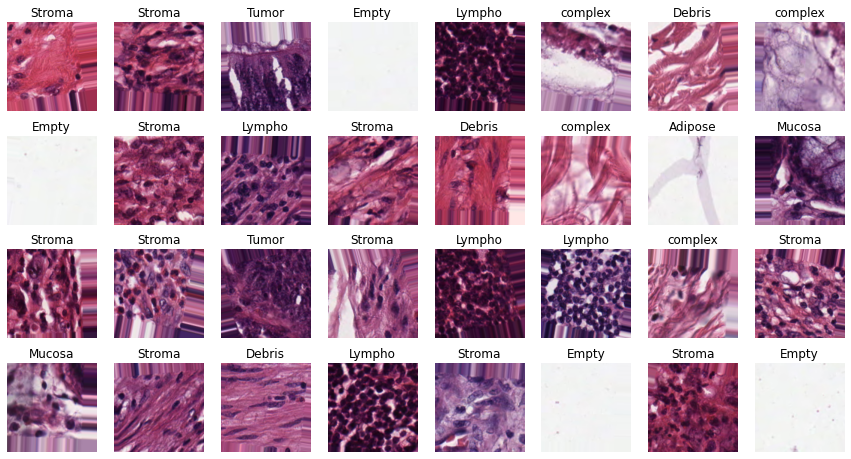

In [ ]:
# preparing and plot image for generator
plot_generator_images(train_generator, all_label_dictionary)

x_batch.shape =  (32, 150, 150, 3)
y_batch.shape =  (32,)


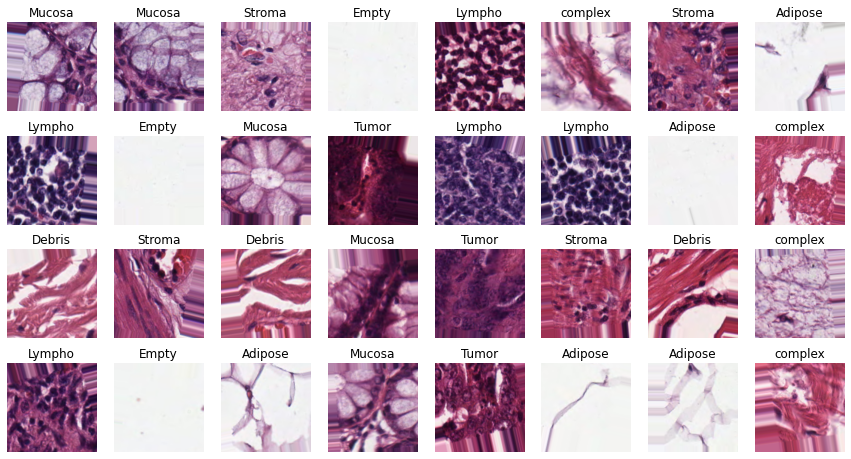

In [ ]:
plot_generator_images(test_generator, all_label_dictionary)

In [ ]:
train_images = train_images.astype('float32') / 255.0    # normalize the images from 0 -> 255 to 0 -> 1
test_images = test_images.astype('float32') / 255.0      

## Model Area

In this sales we will prepare our models
one model preparing from scratch , by my architecture
and second model we using the "transfer learning" this method helps us achieve better results
because we use the existing model already  
we use a model that has already gone through the training process and the weights is prepared


### Model 1
First model architecture I created myself

In [ ]:
model_1 = Sequential()

model_1.add(Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same', input_shape=(150, 150,3)))
model_1.add(BatchNormalization())
model_1.add(Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2))) 
model_1.add(BatchNormalization()) 

model_1.add(Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same'))
model_1.add(BatchNormalization())
model_1.add(Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(BatchNormalization())

model_1.add(Conv2D(128, kernel_size=(3, 3), activation="relu", padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(BatchNormalization())
model_1.add(Conv2D(128, kernel_size=(3, 3), activation="relu", padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(BatchNormalization())
model_1.add(Dropout(0.2))

model_1.add(Conv2D(256, kernel_size=(3, 3), activation="relu", padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(BatchNormalization())
model_1.add(Dropout(0.2))

model_1.add(Flatten())

model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.2))

model_1.add(Dense(1000, activation='relu'))
model_1.add(Dropout(0.5))

model_1.add(Dense(8, activation='softmax'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 75, 75, 64)        2

### Model 2
Model two uses the transfer learning method
using VGG16 model 

In [ ]:
# Re-loads the VGG16 model without the "top" (its fully-connected layers)
model_2 = keras.Sequential()

vgg16 = tf.keras.applications.VGG16(input_shape=(150,150,3),
                                               include_top=False,   
                                               weights='imagenet')
vgg16.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [ ]:
# Let's print our layers 
print('#layer \t layer-name \t trainable')
print('------ \t ---------- \t ---------')

for (i,layer) in enumerate(vgg16.layers):
    print(str(i),'\t', layer.__class__.__name__, '\t',layer.trainable)

vgg16.trainable = False # make all layers not trainable
print("\n  Make all layers not trainable   \n\n")

for (i,layer) in enumerate(vgg16.layers):
    print(str(i),'\t', layer.__class__.__name__, '\t',layer.trainable)

#layer 	 layer-name 	 trainable
------ 	 ---------- 	 ---------
0 	 InputLayer 	 True
1 	 Conv2D 	 True
2 	 Conv2D 	 True
3 	 MaxPooling2D 	 True
4 	 Conv2D 	 True
5 	 Conv2D 	 True
6 	 MaxPooling2D 	 True
7 	 Conv2D 	 True
8 	 Conv2D 	 True
9 	 Conv2D 	 True
10 	 MaxPooling2D 	 True
11 	 Conv2D 	 True
12 	 Conv2D 	 True
13 	 Conv2D 	 True
14 	 MaxPooling2D 	 True
15 	 Conv2D 	 True
16 	 Conv2D 	 True
17 	 Conv2D 	 True
18 	 MaxPooling2D 	 True

  Make all layers not trainable   


0 	 InputLayer 	 False
1 	 Conv2D 	 False
2 	 Conv2D 	 False
3 	 MaxPooling2D 	 False
4 	 Conv2D 	 False
5 	 Conv2D 	 False
6 	 MaxPooling2D 	 False
7 	 Conv2D 	 False
8 	 Conv2D 	 False
9 	 Conv2D 	 False
10 	 MaxPooling2D 	 False
11 	 Conv2D 	 False
12 	 Conv2D 	 False
13 	 Conv2D 	 False
14 	 MaxPooling2D 	 False
15 	 Conv2D 	 False
16 	 Conv2D 	 False
17 	 Conv2D 	 False
18 	 MaxPooling2D 	 False


In [ ]:

model_2.add(vgg16) 

# add a new "top": Flatten(), 256-Dense (ReLU), Dropout(0.5), 8-Dense (Softmax)

model_2.add(Flatten())
model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(8, activation='softmax'))

model_2.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 2056      
Total params: 16,814,152
Trainable params: 2,099,464
Non-trainable params: 14,714,688
_________________________________________________________________


### Train Model And Validation


#### Model 1

In [ ]:
4000//32 # find the "steps_per_epoch"

125

In [ ]:
# compile the model using gradient descent Adam:

Adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.8, beta_2=0.999, epsilon=1e-07) 

# compile the model:
model_1.compile(optimizer=Adam, # stochastic gradient descent
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# in the first training uses a learning rate 0.001 
# relatively large to lower the loss as much as possible down
history_1 = model_1.fit(train_generator, steps_per_epoch=125, epochs=12, 
                    validation_data=(test_generator)) 

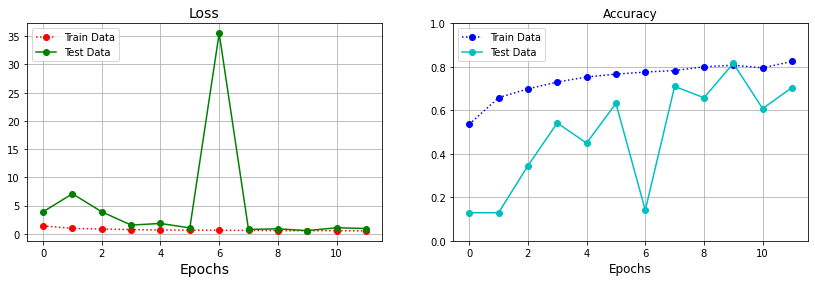

In [ ]:
plot_history_after_training(history_1)

In [ ]:
# compile the model using gradient descent Adam:

Adam = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.6, beta_2=0.999, epsilon=1e-07) 
# compile the model:
model_1.compile(optimizer=Adam, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# second training use learning rate learning rate 0.0001 to adjust the weights a little more
history_1_1 = model_1.fit(train_generator, steps_per_epoch=125, epochs=20, 
                    validation_data=(test_generator)) 

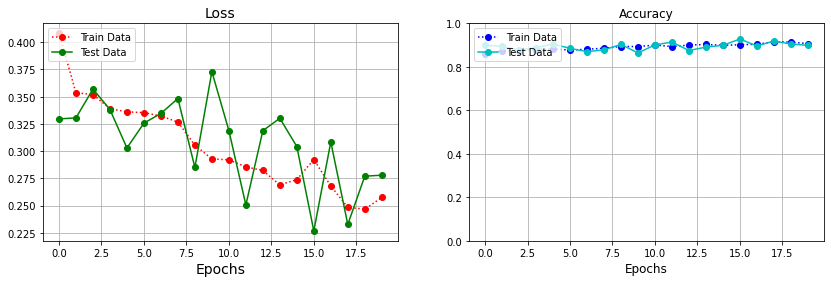

In [ ]:
plot_history_after_training(history_1_1)

In [ ]:
model_1.save('model_1.h5') # save model 1 after the training

#### Model 2

In [ ]:
# compile the model using gradient descent RMSprop:
GD_RMSprop = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.7, epsilon=1e-07)

# compile the model the :
model_2.compile(optimizer=GD_RMSprop,   # The weights are 'frozen' and untrainable 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_weights_freeze = model_2.fit(train_generator, steps_per_epoch=125, epochs=12, validation_data=(test_generator)) 

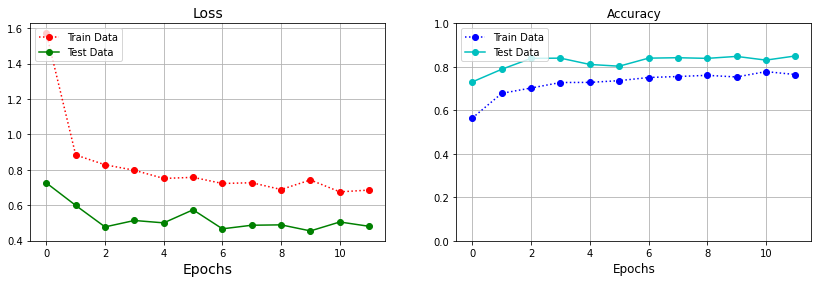

In [ ]:
plot_history_after_training(history_weights_freeze)

In [ ]:
for layer in model_2.layers: # 'unfreeze' the VGG layers
    layer.trainable = True

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 2056      
Total params: 16,814,152
Trainable params: 16,814,152
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# compile the model using gradient descent WITH MOMENTUM:
SGD_momentum = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)  

# compile the model:
model_2.compile(optimizer=SGD_momentum,  #The weights are 'unfreeze' 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
 # Continue the training process
history_unfreeze = model_2.fit(train_generator, steps_per_epoch=125, epochs=20, validation_data=(test_generator)) 

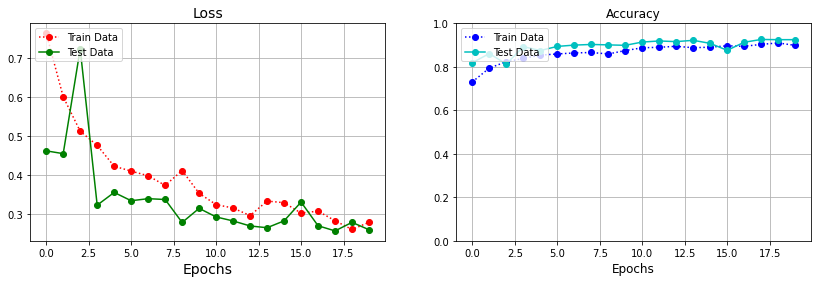

In [ ]:
plot_history_after_training(history_unfreeze)

In [ ]:
model_2.save('model_2.h5') # save model 2 after the training 

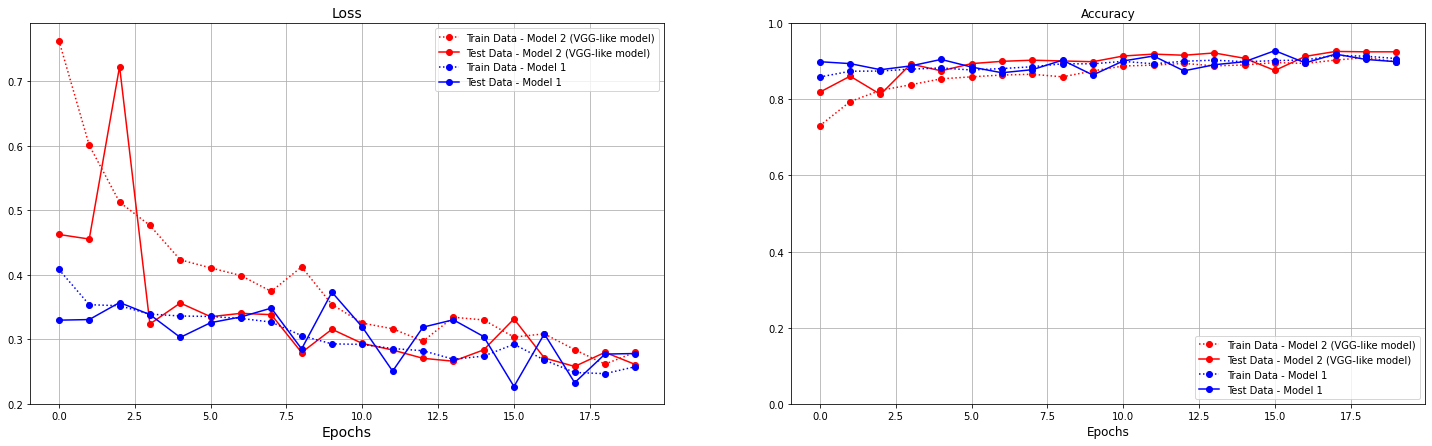

In [ ]:
plt.figure(figsize=(25,7))

plt.subplot(1,2,1)

plt.plot(history_unfreeze.history['loss'],':or',label = "Train Data - Model 2 (VGG-like model)")
plt.plot(history_unfreeze.history['val_loss'],'-or',label = "Test Data - Model 2 (VGG-like model)")

plt.plot(history_1_1.history['loss'],':ob',label = "Train Data - Model 1")
plt.plot(history_1_1.history['val_loss'],'-ob',label = "Test Data - Model 1")

plt.title('Loss',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.legend(loc = "upper right")
plt.grid()

plt.subplot(1,2,2)

plt.plot(history_unfreeze.history['accuracy'],':or',label = "Train Data - Model 2 (VGG-like model)")
plt.plot(history_unfreeze.history['val_accuracy'],'-or',label = "Test Data - Model 2 (VGG-like model)")

plt.plot(history_1_1.history['accuracy'],':ob',label = "Train Data - Model 1")
plt.plot(history_1_1.history['val_accuracy'],'-ob',label = "Test Data - Model 1")

plt.ylim([0, 1])
plt.title('Accuracy',fontsize=12)
plt.xlabel('Epochs',fontsize=12)
plt.legend(loc = "lower right")
plt.grid()

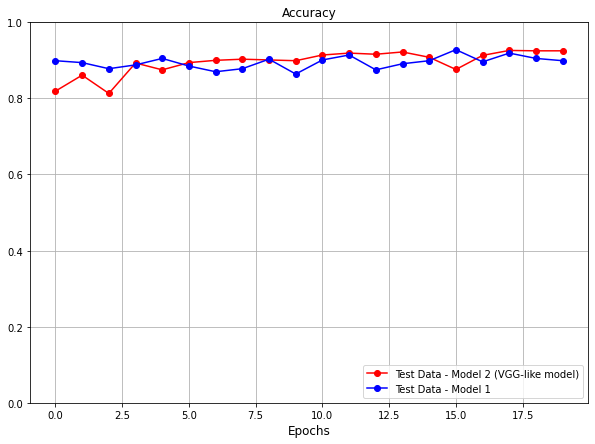

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(history_unfreeze.history['val_accuracy'],'-or',label = "Test Data - Model 2 (VGG-like model)")

plt.plot(history_1_1.history['val_accuracy'],'-ob',label = "Test Data - Model 1")


  
plt.ylim([0, 1])
plt.title('Accuracy',fontsize=12)
plt.xlabel('Epochs',fontsize=12)
plt.legend(loc = "lower right")
plt.grid()

## Predict Model 

In [ ]:
# Success rates for the first model

score = get_accuracy_and_loss(model_1, test_images, test_labels)  
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.24309702217578888
Test accuracy: 0.9120000004768372


In [ ]:
# Success rates for the second model

score = get_accuracy_and_loss(model_2, test_images, test_labels)  
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.25936946272850037
Test accuracy: 0.9290000200271606


### Confusion matrix

Plot the confusion matrix for the last model.


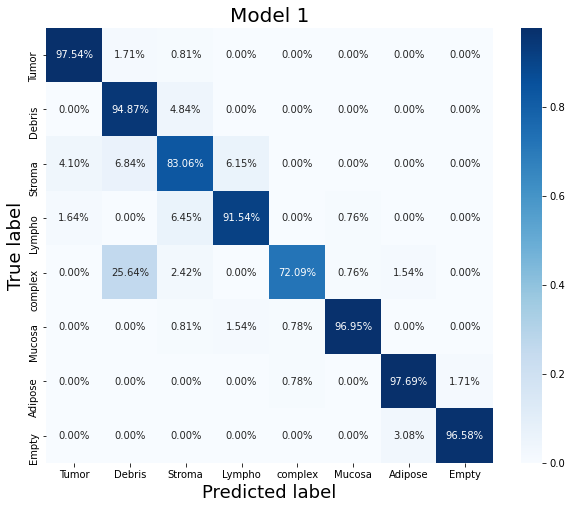

In [ ]:
plot_confusion_matrix(model_1,all_label_dictionary.values(),test_images,test_labels,'Model 1')

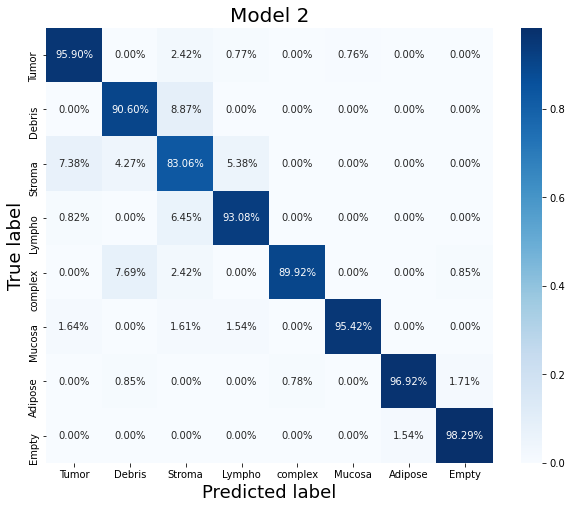

In [ ]:
plot_confusion_matrix(model_2,all_label_dictionary.values(),test_images,test_labels,'Model 2')


### Summarize 

it can be seen that the second model gave us the better results

in this model we used transfer learning

<table>
  <tr>
    <th>Model</th>
    <th>#parameters</th>
    <th>batch-size</th>
    <th>epochs</th>
    <th>accuracy</th>
    <th>Loss</th>
  </tr>
    
  <!-- copy this block once for every model you tested -->  
  <tr> 
    <td> Model 1 </td>   <!-- Model -->
    <td> 1,246,416 </td> <!-- #parameters -->
    <td> 128 </td> <!-- batch-size -->
    <td> 32 </td> <!-- epochs -->
    <td> 0.912 </td> <!-- accuracy -->
    <td> 0.243 </td> <!-- Loss -->
  </tr>
  <tr> 
    <td>Model 2</td>   <!-- Model -->
    <td> 16,814,152 </td> <!-- #parameters -->
    <td> 128 </td> <!-- batch-size -->
    <td> 32 </td> <!-- epochs -->
    <td> 0.929 </td> <!-- accuracy -->
    <td> 0.259 </td> <!-- Loss -->
  </tr>
     
</table>




### Select the best model

In [ ]:
model = tf.keras.models.load_model('model_2.h5')  # We will upload the best model
                                                  # and use it to continue the project

## Features Visualization

### Function For *Visualization*

In [ ]:
def get_specifically_layers(model, end_layer):  # The function get layers from 0 to parameter end_layer
  return keras.Model(inputs=model.inputs, outputs=model.layers[end_layer].output)


def plot_activation_maps(i_model, i_layers_list, i_img): # The function plot the activation map 

  for index_layer in i_layers_list:

    activations = get_specifically_layers(i_model,index_layer)  
    a = activations.predict(i_img)

    plt.figure(figsize=(20,20))
    for i in range(10):
      plt.subplot(1,10,i+1)
      plt.imshow(a[0,:,:,i], cmap='hot')
      plt.xticks([])
      plt.yticks([])
    plt.show()

def plot_features_space(features_extractor, test_images): # The function plot features space 
                                                          # gets a final layer of the model and the image we want to test
  features = features_extractor.predict(test_images)

  plt.figure(figsize=(20,7))
  plt.plot(features[1,::],"-ob")
  plt.title("Features Space",fontsize=20)
  plt.show()

def plot_features_reduce_dimensionality(features_extractor, test_images, test_labels):

  features = features_extractor.predict(test_images)                 # get the features of all the images after predict
  features_2D = TSNE(n_components=2).fit_transform(features[:500,::])# conv the features to 2d
  # Uses only 500 to optimize the program
  test_images_2D = test_images[:500,::].reshape(500,-1)     # get all the images as they are
  img_2D =TSNE(n_components=2).fit_transform(test_images_2D)# conv the images to 2d
  
  plt.figure(figsize=(17,5))
  plt.subplot(1,2,1)
  plt.title("TSNE: features 1000-D to 2-D",fontsize=18)
  plt.scatter(features_2D[:,0], features_2D[:,1], s=100, c=test_labels[:500], cmap='tab20', alpha=0.8)
  
  plt.subplot(1,2,2)
  plt.title("TSNE: images (150,150,3) -> 67500-D to 2-D",fontsize=18)
  plt.scatter(img_2D[:,0], img_2D[:,1], s=100, c=test_labels[:500], cmap='tab20', alpha=0.8)
  plt.show()

def maximally_activating_patches(i_list_filter_id, i_activations, i_x_test, i_pad_num, i_size_of_the_img_EndToEnd):

  for filter_id in i_list_filter_id:

    p = i_activations[:,:,:,filter_id].copy()

    pp = p.reshape(1,-1)

    ppp = pp[0,::]

    idx_list = [] 

    S = 1
    for i in range(0,6,1):
      idx_list.append(np.argmax(ppp))
      ppp[np.argmax(ppp)] = 0

    patch_list = []

    for i,idx in enumerate(idx_list):
      (img_idx, i, j) = np.unravel_index(idx, i_activations.shape[:3])

      img = i_x_test[img_idx]

      img_padded = np.pad(img,((i_pad_num,i_pad_num),(i_pad_num,i_pad_num),(0,0)))
      patch = img_padded[S*i:S*i+i_size_of_the_img_EndToEnd, S*j:S*j+i_size_of_the_img_EndToEnd, :]

      patch_list.append(patch)


    plt.figure(figsize=(10,10))
    for i,x in enumerate(patch_list):
        plt.subplot(1,6,i+1)
        plt.imshow(x)
        plt.axis('off')
    plt.show()
  

In [ ]:
for i,l in enumerate(model.layers):
    print(i,'\t','\t',l.name)

0 	 	 conv2d
1 	 	 batch_normalization
2 	 	 conv2d_1
3 	 	 max_pooling2d
4 	 	 batch_normalization_1
5 	 	 conv2d_2
6 	 	 batch_normalization_2
7 	 	 conv2d_3
8 	 	 max_pooling2d_1
9 	 	 batch_normalization_3
10 	 	 conv2d_4
11 	 	 max_pooling2d_2
12 	 	 batch_normalization_4
13 	 	 conv2d_5
14 	 	 max_pooling2d_3
15 	 	 batch_normalization_5
16 	 	 dropout
17 	 	 conv2d_6
18 	 	 max_pooling2d_4
19 	 	 batch_normalization_6
20 	 	 dropout_1
21 	 	 flatten
22 	 	 dense
23 	 	 dropout_2
24 	 	 dense_1
25 	 	 dropout_3
26 	 	 dense_2


### Visualization

Activation Maps

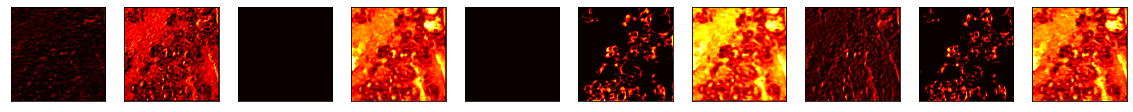

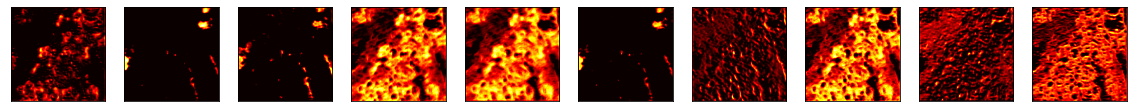

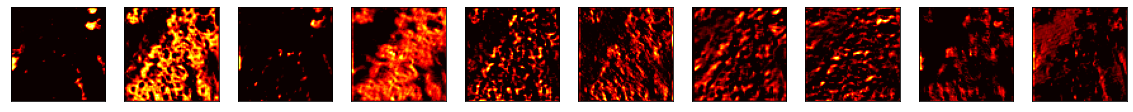

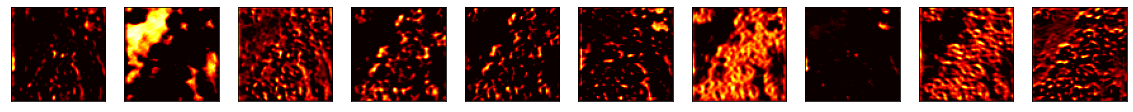

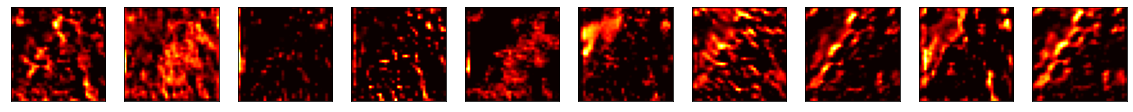

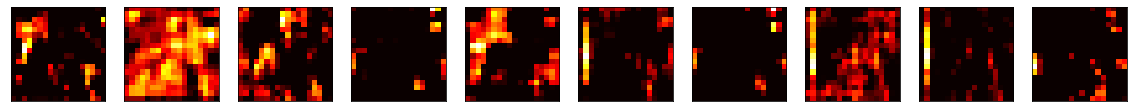

In [ ]:
plot_activation_maps(model,[0,2,5,7,10,13],train_images[None,0])

Features Space

In [ ]:
features_extractor = get_specifically_layers(model, -3)
features_extractor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16_input (InputLayer)     [(None, 150, 150, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
Total params: 16,812,096
Trainable params: 16,812,096
Non-trainable params: 0
_________________________________________________________________


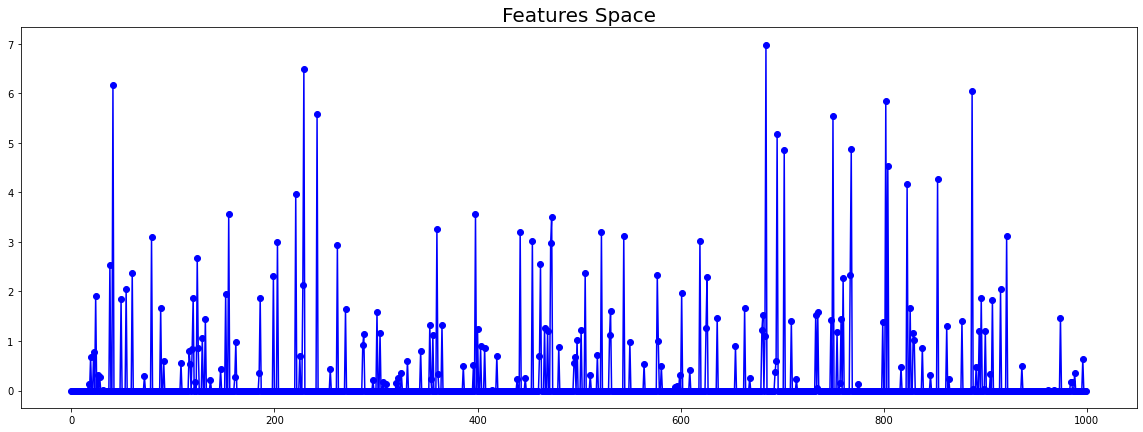

In [ ]:
plot_features_space(features_extractor, test_images)

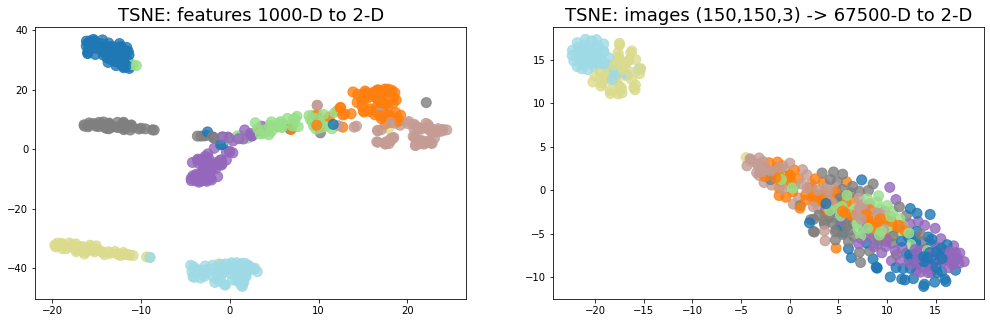

In [ ]:
plot_features_reduce_dimensionality(features_extractor, test_images ,test_labels)
# you can see the division that the model made for the image features compared to the raw images
# as you can see there is really a division into 8 categories

Maximally Activating Patches

(1000, 150, 150, 32)


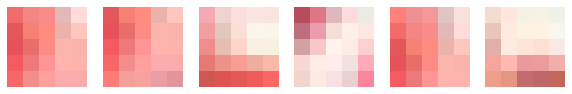

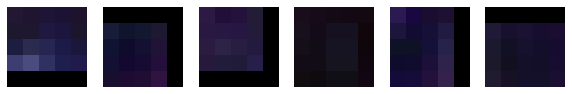

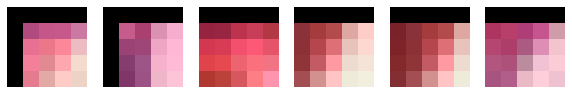

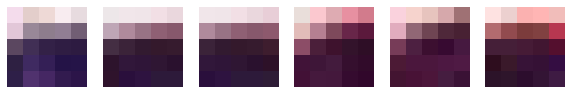

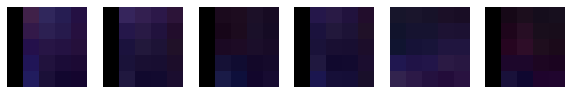

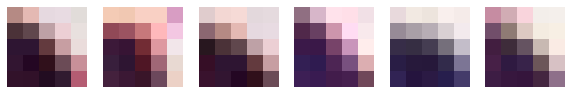

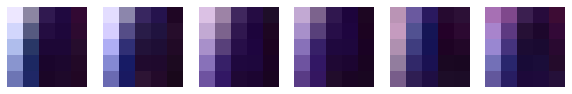

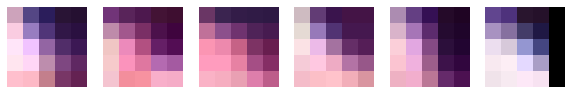

In [ ]:
activations_extractor = get_specifically_layers(model,2)
activations = activations_extractor.predict(test_images)
print(activations.shape)
maximally_activating_patches([1,4,8,9,16,21,25,30],activations,test_images,2,5)

(1000, 75, 75, 64)


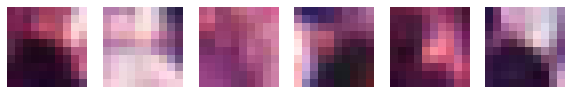

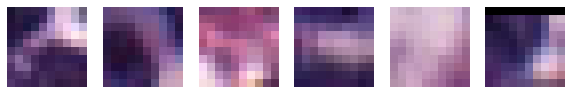

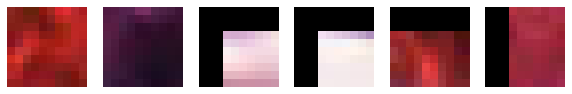

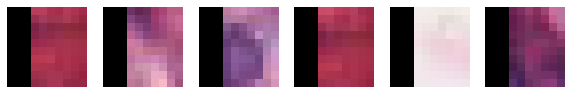

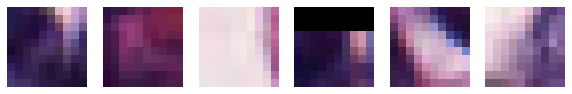

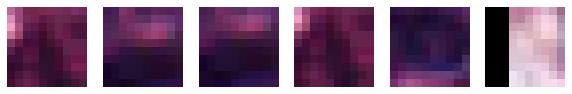

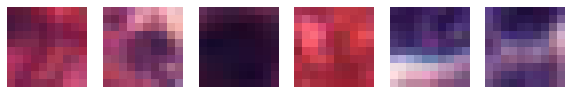

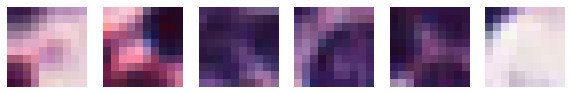

In [ ]:
activations_extractor = get_specifically_layers(model_1,5)
activations = activations_extractor.predict(test_images)
print(activations.shape)
maximally_activating_patches([2,4,8,9,16,21,25,30],activations,test_images,4,10)

(1000, 75, 75, 64)


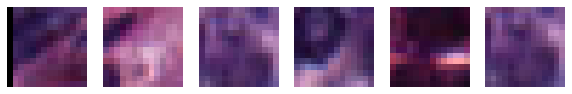

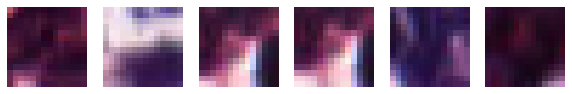

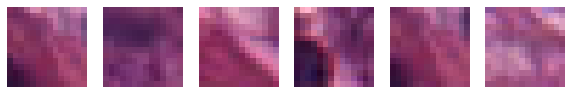

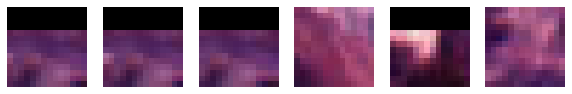

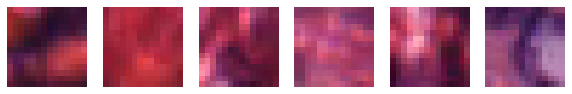

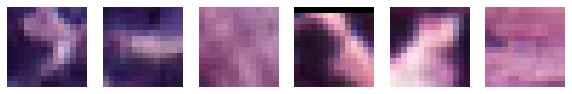

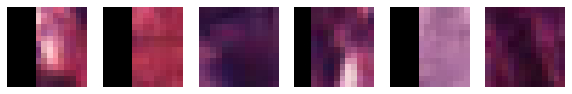

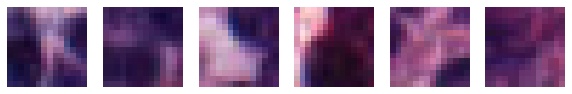

In [ ]:
activations_extractor = get_specifically_layers(model_1,7)
activations = activations_extractor.predict(test_images)
print(activations.shape)
maximally_activating_patches([2,4,8,9,16,21,25,30],activations,test_images,6,14)

## Testing the Model in Large Images

### Global function to load data and preparing the test set

In [ ]:
def load_large_images_to_test():  # load the raw test data from database in tensorflow
  return tfds.as_numpy(tfds.load('colorectal_histology_large',split=['test'],batch_size=-1,))

def get_from_the_large_image_test_set(large_image): # Cut out the small image (150,150,3) from the big picture (5000,5000,3)
  l = []
  for i in range(0,5000,50):
    for j in range(0,5000,50):
      if large_image[i:i+150,j:j+150,:].shape == (150,150,3):
        l.append(large_image[i:i+150,j:j+150,:])

  return np.asarray(l)


In [ ]:
large_images_to_test = load_large_images_to_test() # get large images

In [ ]:
large_images_to_test[0]['image'].shape # print their shape 

(10, 5000, 5000, 3)

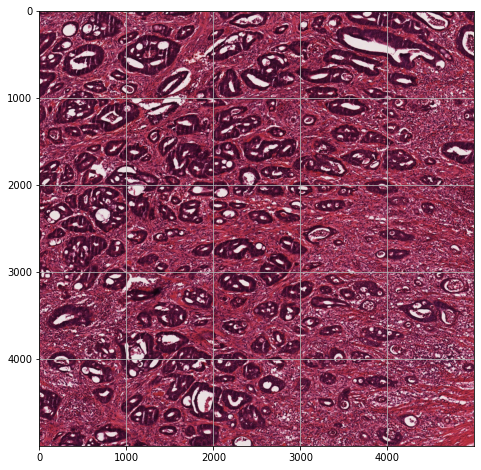

In [ ]:
plt.figure(figsize=(15,8))    # plot the first large image
plt.imshow(large_images_to_test[0]["image"][1])
plt.grid()
plt.show()

### Select test large image

In [ ]:
large_image = large_images_to_test[0]["image"][7].copy()  #  select the image we want to process

In [ ]:
large_image.shape

(5000, 5000, 3)

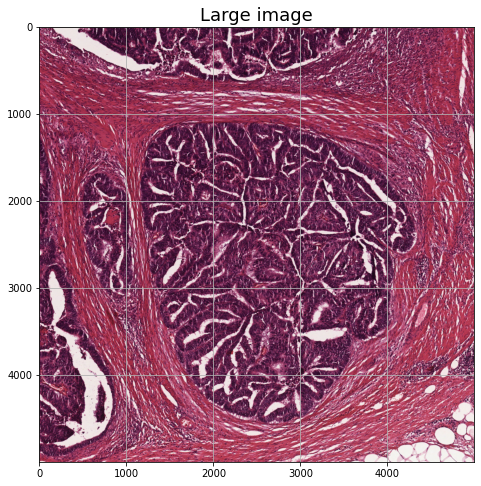

In [ ]:
plt.figure(figsize=(15,8))  # plot this image
plt.imshow(large_image)
plt.grid()
plt.title('Large image',fontsize=18)
plt.show()

### Preparing the image to test

In [ ]:
large_image = large_image.astype('float32') / 255.0  # normalize the images from 0 -> 255 to 0 -> 1

In [ ]:
test_data = get_from_the_large_image_test_set(large_image) # From the big imge we will make our small pictures 
test_data.shape                                            # for a test set

(9604, 150, 150, 3)

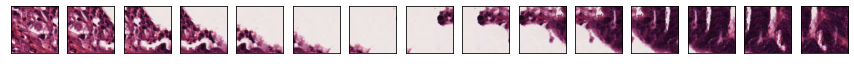

In [ ]:
plt.figure(figsize=(15,8))  # plot the test set
for i in range(15):
    plt.subplot(1,15,i+1)
    plt.imshow(test_data[i])
    plt.xticks([]), plt.yticks([])
plt.show()


In [ ]:
predict_data = model.predict(test_data)  # predict test data
predict_data.shape

(9604, 8)

In [ ]:
predict_data

array([[5.81628177e-03, 1.23640232e-01, 8.32352936e-01, ...,
        2.54506106e-03, 1.81593039e-14, 4.14381984e-17],
       [1.28194075e-02, 1.10852323e-01, 8.09497476e-01, ...,
        9.70552024e-03, 9.91597212e-13, 6.42195393e-15],
       [1.27271429e-01, 3.75032015e-02, 6.16120756e-01, ...,
        8.79270658e-02, 8.46077981e-08, 1.73252190e-10],
       ...,
       [9.08834030e-14, 1.03091668e-06, 1.66415970e-14, ...,
        1.42076370e-16, 9.99815643e-01, 2.64693614e-11],
       [9.64348379e-10, 1.13937454e-02, 6.16643092e-09, ...,
        2.61609582e-13, 9.77717280e-01, 1.64825948e-08],
       [4.21864740e-07, 8.08758974e-01, 3.14938989e-05, ...,
        8.71039241e-09, 6.31527007e-02, 2.56981831e-08]], dtype=float32)

In [ ]:
final_clasifir = np.zeros((98,98))
final_clasifir.shape

(98, 98)

In [ ]:
final_clasifir_probability = np.zeros((98,98))
final_clasifir_probability.shape


(98, 98)

In [ ]:
index = 0
for i in range(0,98,1):
  for j in range(0,98,1):
    final_clasifir[i,j] = np.argmax(predict_data[index])  
    final_clasifir_probability[i,j] = predict_data[index][0]        
    index += 1 


## Final predict result of the model  

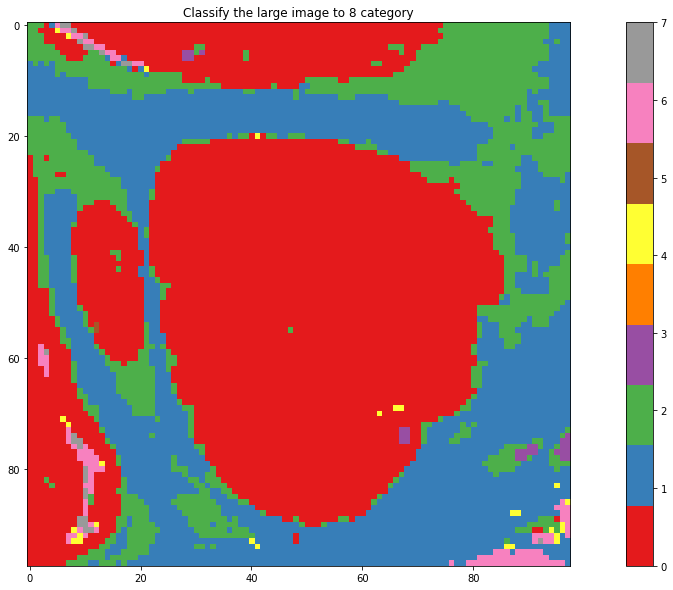

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(final_clasifir,cmap='Set1')
plt.colorbar()
plt.title('Classify the large image to 8 category' , fontsize=18)
plt.show()

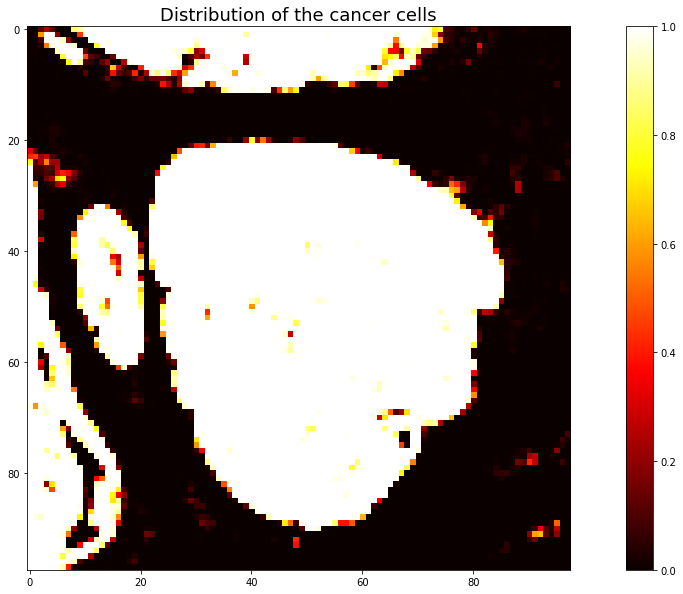

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(final_clasifir_probability,cmap='hot')
plt.colorbar()
plt.title('Distribution of the cancer cells',fontsize=18)
plt.show()

#Plot all larges images

In [ ]:
def plot_all_larges_images(large_images_to_test,model):

  for larg_image in large_images_to_test[0]["image"]:
    large_image_copy = larg_image.copy() 
    large_image_copy = large_image_copy.astype('float32') / 255.0  # normalize the images from 0 -> 255 to 0 -> 1
    test_data = get_from_the_large_image_test_set(large_image_copy)
    predict_data = model.predict(test_data)

    final_clasifir_probability = np.zeros((98,98))

    final_clasifir = np.zeros((98,98))

    index = 0
    for i in range(0,98,1):
      for j in range(0,98,1):
        final_clasifir[i,j] = np.argmax(predict_data[index])  
        final_clasifir_probability[i,j] = predict_data[index][0]        
        index += 1 


    plt.figure(figsize=(15,7))
    plt.subplot(1,3,1)
    an_image = plt.imshow(final_clasifir,cmap='Set1')
    plt.colorbar(an_image, shrink=0.60)
    plt.title('Classify the large image to 8 category' , fontsize=10)
    
    plt.subplot(1,3,2)
    an_image = plt.imshow(final_clasifir_probability,cmap='hot')
    plt.colorbar(an_image, shrink=0.60)
    plt.title('Distribution of the cancer cells',fontsize=10)

    plt.subplot(1,3,3)
    plt.imshow(larg_image)
    plt.title('Large image',fontsize=10)

    plt.show()
  

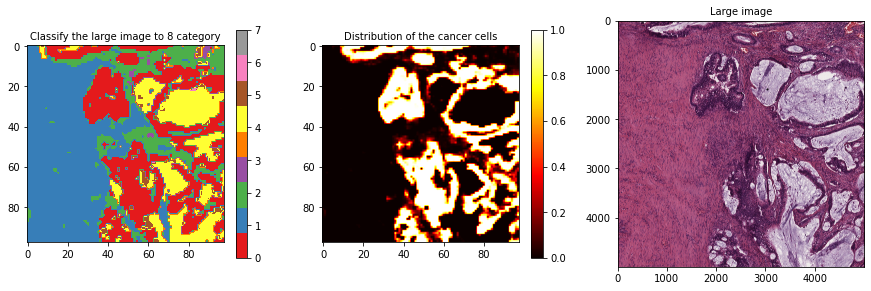

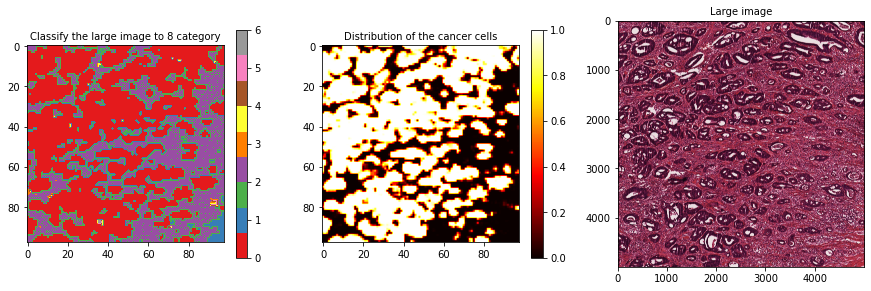

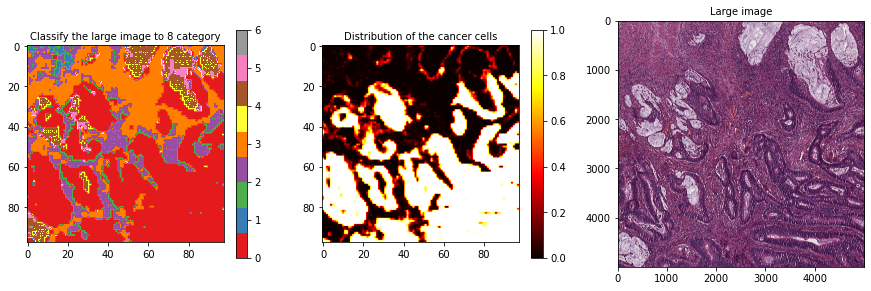

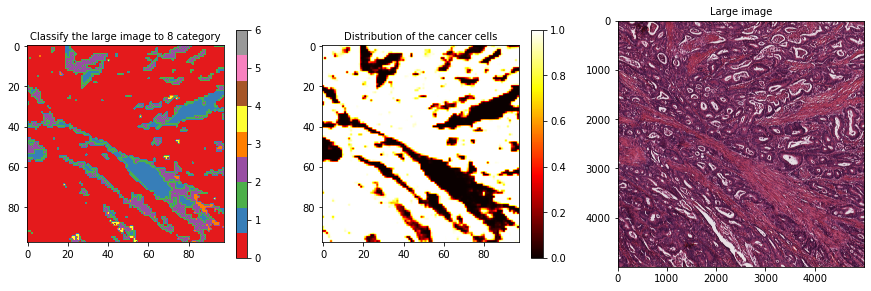

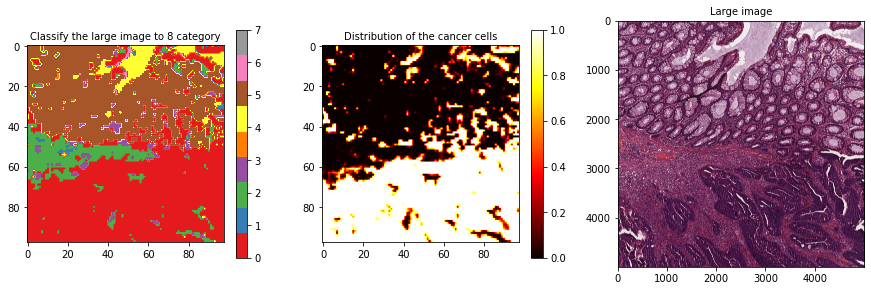

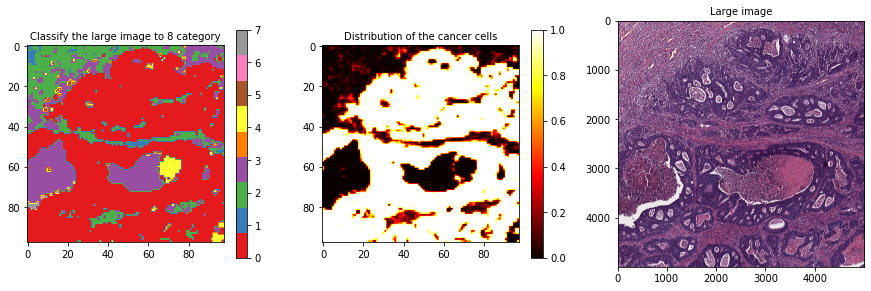

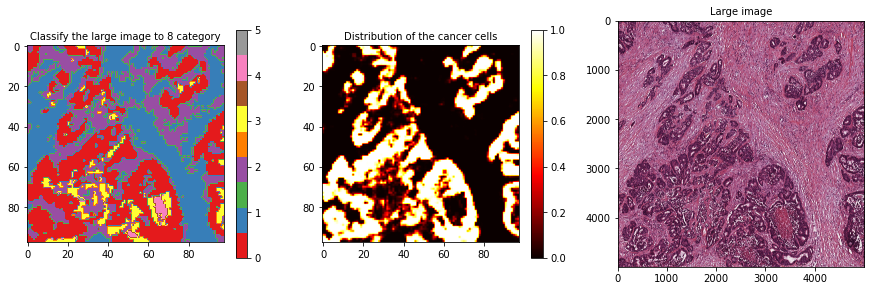

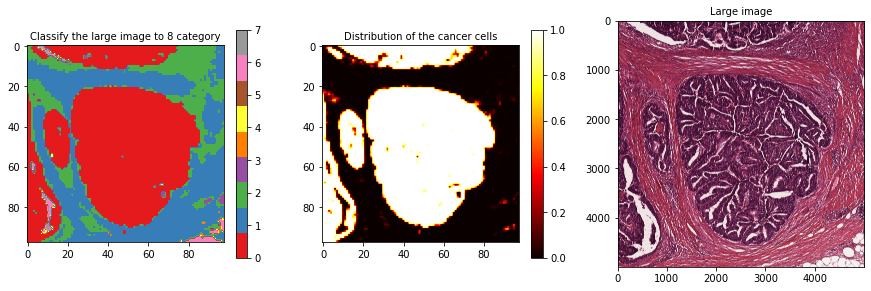

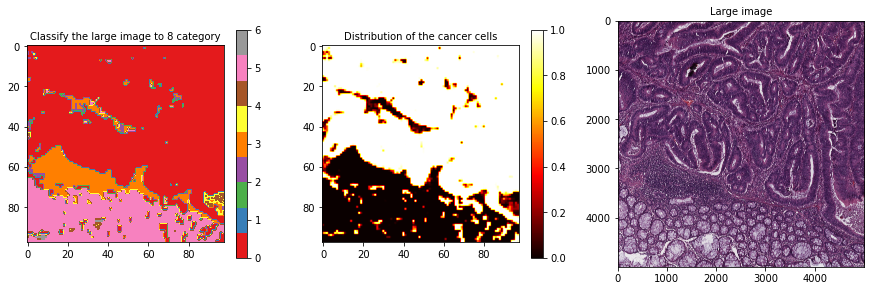

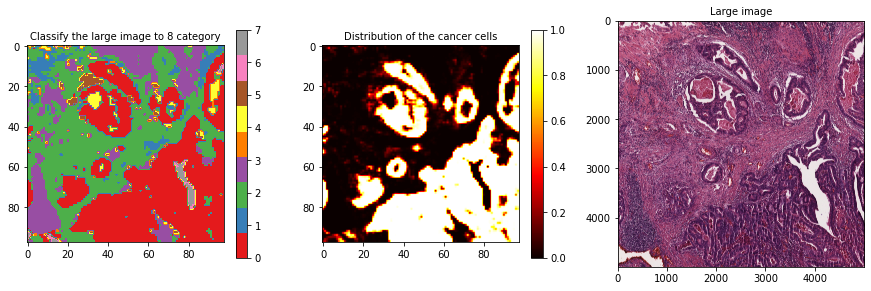

In [ ]:
plot_all_larges_images(large_images_to_test,model)
